In [1]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
plt.style.use('ggplot')

In [2]:
#plt.style.use(['dark_background'])

In [3]:
train = pd.read_csv('drugsComTrain_raw.csv')
test = pd.read_csv('drugsComTest_raw.csv')

In [4]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [5]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [6]:
list(train)

['uniqueID',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

In [7]:
list(test)

['uniqueID',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

In [8]:
list(train)==list(test)

True

In [9]:
cond = train.condition.value_counts().sort_values(ascending=False)

In [10]:
cond[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [11]:
plt.rcParams['figure.figsize']=[16,10]

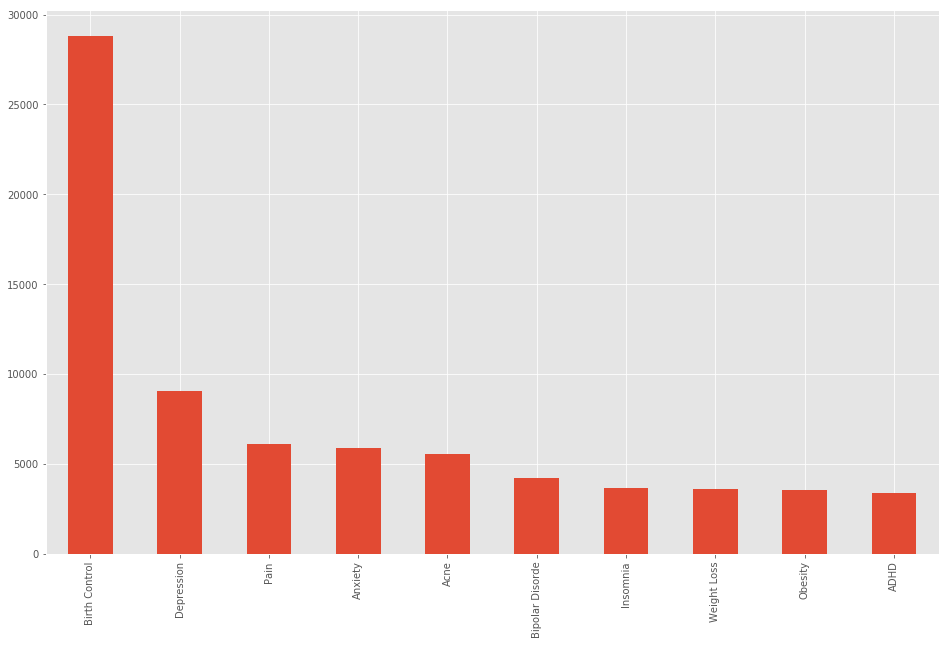

In [12]:
#top 10 plot
cond[:10].plot(kind='bar')

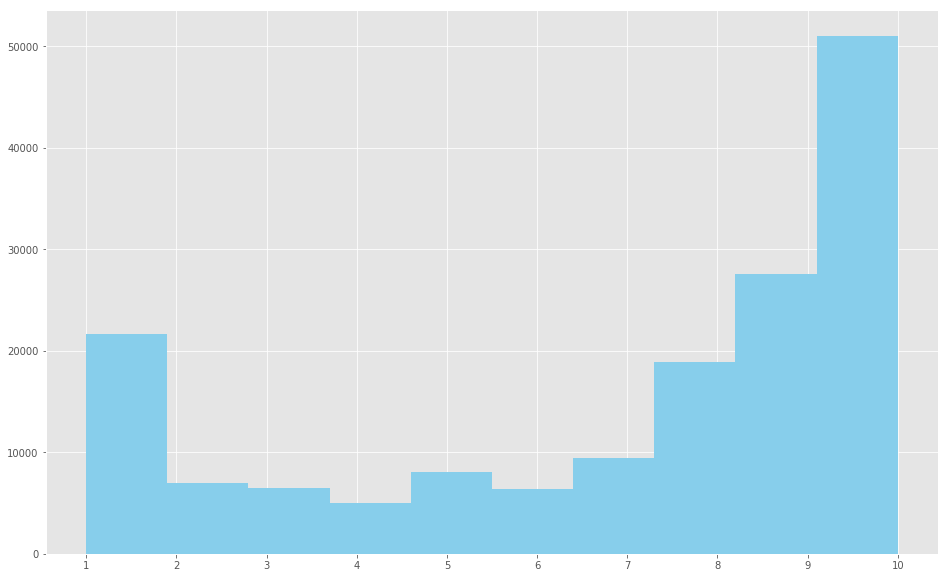

In [13]:
train.rating.hist(color='skyblue')
plt.xticks([i for i in range(1, 11)]);


In [14]:
rating_avg = (train['rating'].groupby(train['drugName']).mean())

Text(0.5, 1.0, 'distribution of drug rating')

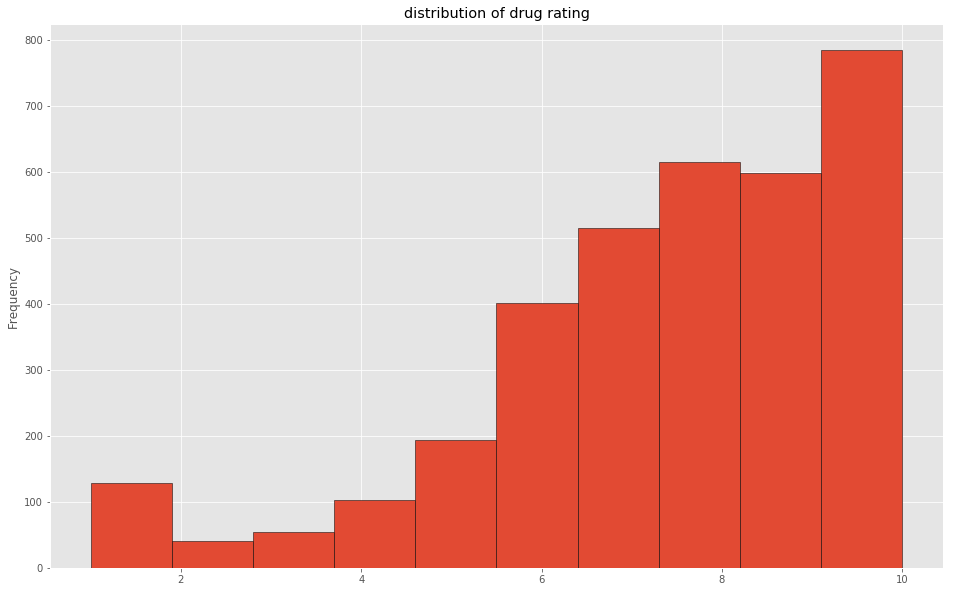

In [15]:
rating_avg.plot(kind='hist',edgecolor='black')
plt.title('distribution of drug rating')

In [16]:
#groupby condition

rating_cond = (train['rating'].groupby(train['condition']).mean())

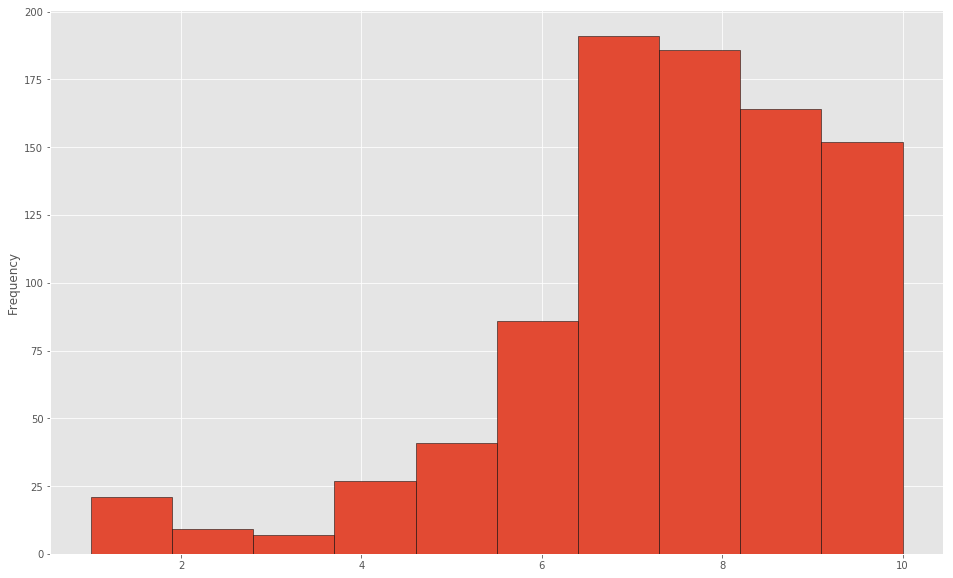

In [17]:
rating_cond.plot(kind='hist',edgecolor='black')

# Is rating correlated with usefulness of the review?


([<matplotlib.axis.XTick at 0x1941acc4cf8>,
 <a list of 10 Text xticklabel objects>)

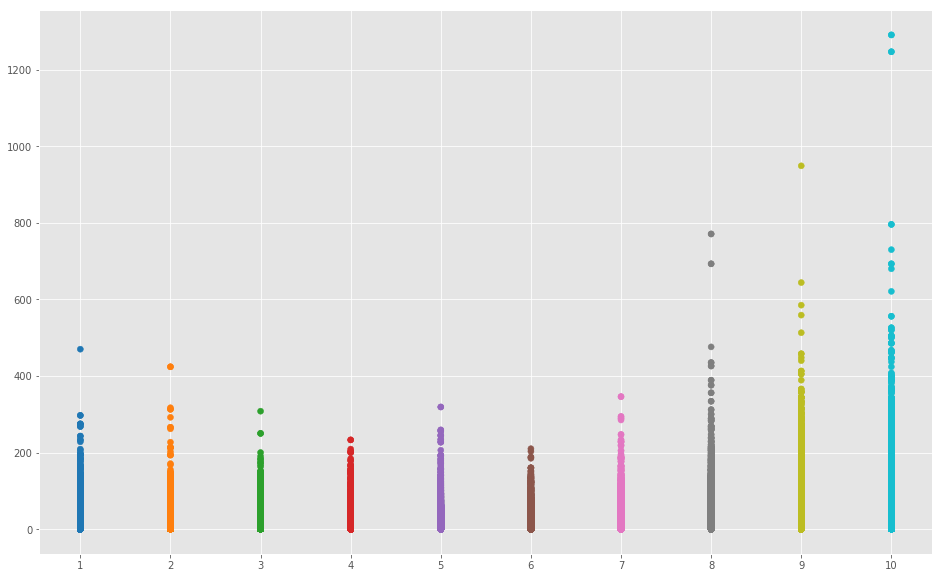

In [18]:
plt.scatter(train.rating, train.usefulCount, c=train.rating.values, cmap='tab10')
plt.xticks([i for i in range(1,11)])

In [19]:
#create a list ( cast into array) avg usefulness for given rating

use_ls = []
for i in range(1,11):
    use_ls.append([i,np.sum(train[train.rating==i].usefulCount)/np.sum(train.rating==i)])
use_arr = np.asarray(use_ls)

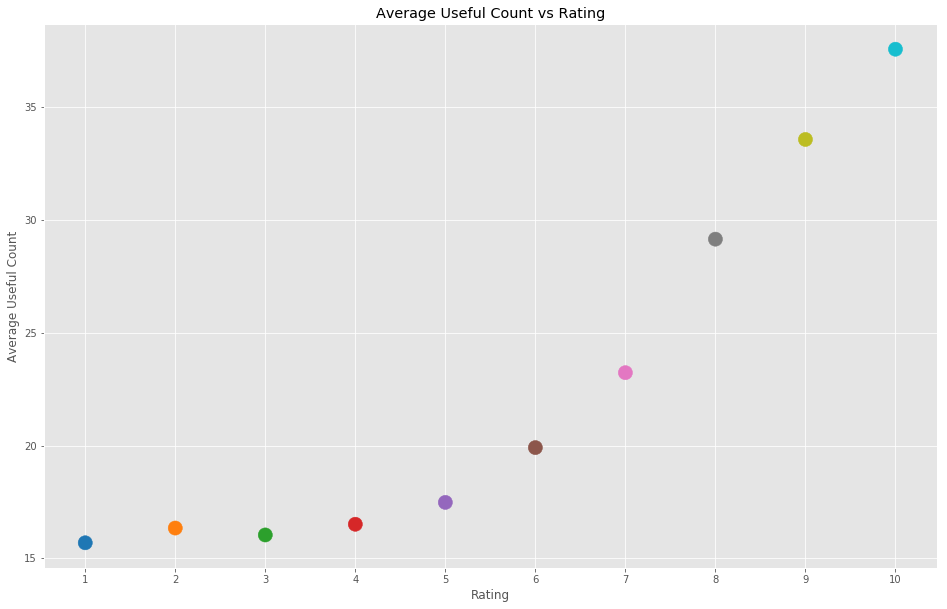

In [20]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);

In [21]:

#Looks like people found reviews with higher scores to be more useful! In the sense that reviews with high ratings recieved more 'useful' tags than reviews with low ratings. Interesting...

In [22]:
useful_train =train.sort_values(by='usefulCount',ascending=False)

In [23]:
useful_train.iloc[:10]

,uniqueID,drugName,condition,review,rating,date,usefulCount
6716,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
33552,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
21708,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
146145,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949
58608,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
16889,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
2039,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
152838,89825,Celexa,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
5218,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10,19-Jul-10,730


In [24]:
for i in useful_train.review.iloc[:3]:
    print(i,'\n')

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remember reading people&#039;s

In [25]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

In [26]:
sid = SentimentIntensityAnalyzer()

In [27]:
sentiments = []

In [28]:
for i in train.review:
    sentiments.append(sid.polarity_scores(i).get('compound'))

In [29]:
sentiments = np.asarray(sentiments)

In [30]:
sentiments

array([-0.296 ,  0.8603,  0.7645, ..., -0.743 ,  0.6197,  0.6124])

In [31]:
useful_train['sentiments'] = pd.Series(data=sentiments)

In [32]:
useful_train = useful_train.reset_index(drop=True)


In [33]:
useful_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiments
0,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
1,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
2,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
3,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
4,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949,-0.6815


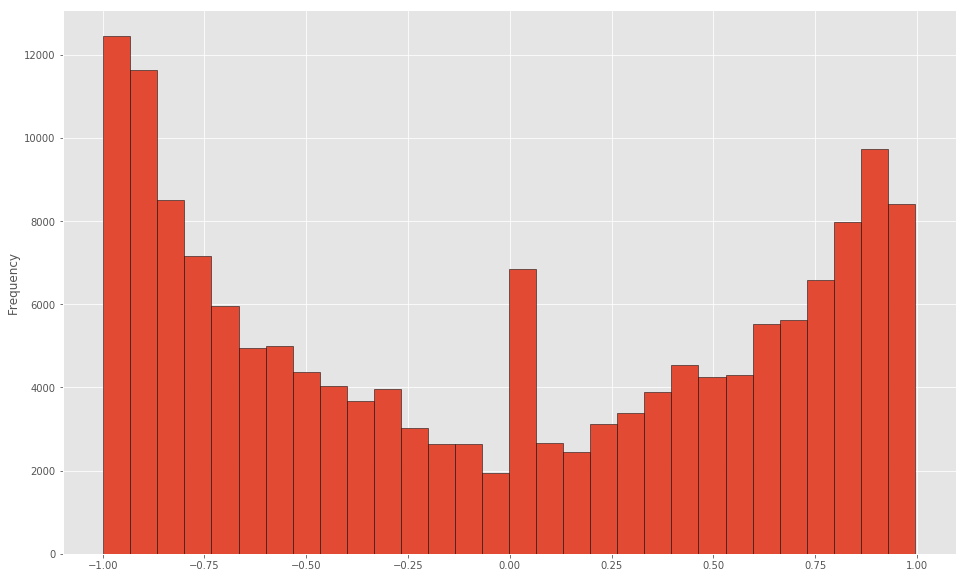

In [34]:
#.hist(,edge_color='black')
useful_train.sentiments.plot(kind='hist',edgecolor='black',bins=30)

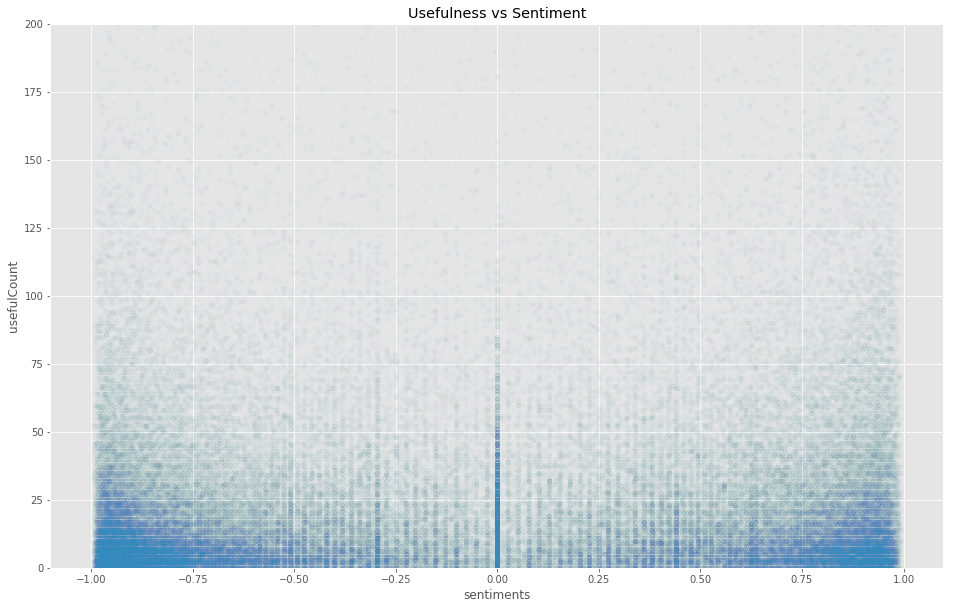

In [35]:
useful_train.plot(x='sentiments', y='usefulCount', kind='scatter', alpha=0.01)
plt.title('Usefulness vs Sentiment')
plt.ylim(0, 200);

In [36]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(useful_train[useful_train.rating == i].sentiments) / np.sum(useful_train.rating == i))

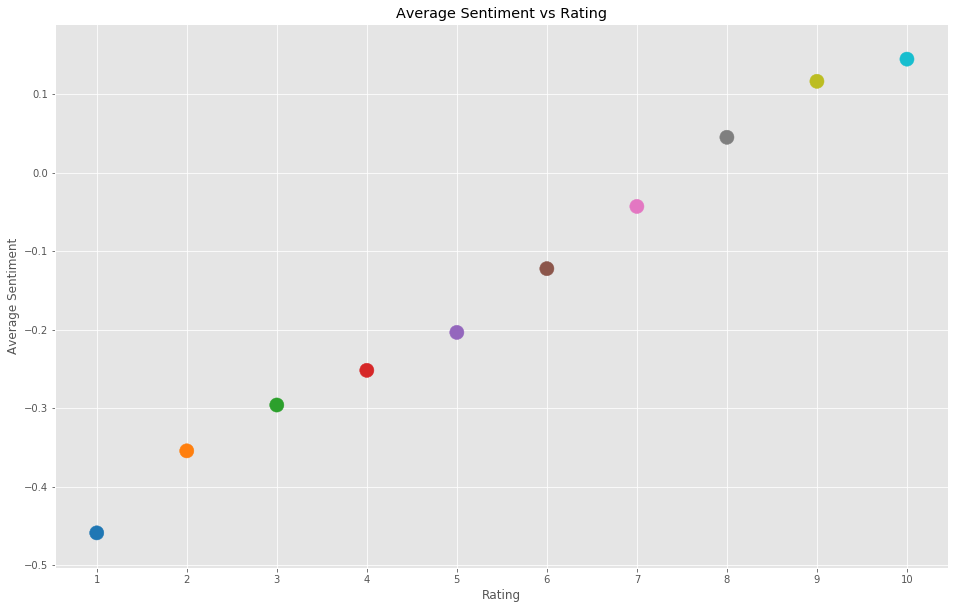

In [37]:
plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 11)]);

In [38]:
#list of drugs & avg ratings
rate_ls = []
for i in train.drugName.unique():
    if np.sum(train.drugName==i)>=10:
        rate_ls.append((i, np.sum(train[train.drugName == i].rating) / np.sum(train.drugName == i)))
        

In [39]:
avg_rate = pd.DataFrame(rate_ls)


In [40]:
# Sort drugs by their ratings, look at top 10 best and worst rated drugs
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

,0,1
0,Zutripro,10.000000
1,Chlorpheniramine / hydrocodone / pseudoephedrine,10.000000
2,Silver sulfadiazine,9.972222
3,Drixoral Cold and Allergy,9.948718
4,Dexbrompheniramine / pseudoephedrine,9.947368
5,Emend,9.900000
6,Aprepitant,9.900000
7,Tegaserod,9.812500
8,Zelnorm,9.687500
9,Cyanocobalamin,9.666667


In [41]:
avg_rate[-10:]

,0,1
1371,Prevnar 13,3.363636
1372,Fosamax,3.166667
1373,Blisovi 24 Fe,3.088889
1374,Opdivo,3.083333
1375,Miconazole,3.033000
1376,Monistat 7,3.032258
1377,Alendronate,2.954545
1378,Yuvafem,2.318182
1379,Monistat 1-Day or Night Combination Pack,1.416667
1380,ProAir RespiClick,1.193548


In [42]:
#best and worst drug by cond

In [43]:
help_dict = {}


In [44]:
for i in train.condition.unique():
    temp_ls=[]
    # Iterate over drugs within a given condition
    for j in train[train.condition == i].drugName.unique():
        if np.sum(train.drugName == j) >=10:
            temp_ls.append((j,np.sum(train[train.drugName==j].rating)/np.sum(train.drugName==j)))
    help_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'average_rating']).sort_values(by='average_rating', ascending=False).reset_index(drop=True)
        
    

In [45]:
help_dict

{'Left Ventricular Dysfunction':          drug  average_rating
 0       Coreg        7.607143
 1   Toprol-XL        7.289474
 2  Benazepril        6.700000
 3      Diovan        6.644444
 4  Metoprolol        6.632558
 5  Carvedilol        6.149254
 6   Valsartan        5.942029,
 'ADHD':                                    drug  average_rating
 0                               Desoxyn        9.588235
 1                           Desipramine        9.285714
 2                           Methylin ER        8.700000
 3                     Dextroamphetamine        8.687500
 4                       Methamphetamine        8.625000
 5                             Dexedrine        8.620690
 6                            Selegiline        8.538462
 7                              Adderall        8.368159
 8                              Methylin        8.272727
 9                              Daytrana        8.244444
 10                          Adderall XR        8.210526
 11      Amphetamine / dext

In [46]:
help_dict['Birth Control'].iloc[:10]


,drug,average_rating
0,Plan B,8.674917
1,Lybrel,7.600000
2,Ortho Evra,7.470320
3,Kyleena,7.463576
4,Levonorgestrel,7.391031
5,Ortho-Cept,7.250000
6,Skyla,7.246359
7,Copper,7.235197
8,Beyaz,7.042553
9,Dienogest / estradiol,6.875000


In [47]:
help_dict['Acne'].iloc[-10:]

,drug,average_rating
64,Ethinyl estradiol / norethindrone,5.591930
65,Sulfamethoxazole / trimethoprim,5.557875
66,Junel Fe 1 / 20,5.404545
67,Loryna,5.162791
68,Tri-Previfem,4.984615
69,Junel Fe 1.5 / 30,4.961538
70,Gildess Fe 1.5 / 30,4.791667
71,SMZ-TMP DS,4.666667
72,Gildess Fe 1 / 20,4.594286
73,Estarylla,3.707317


In [48]:
vectorizer = TfidfVectorizer()

In [49]:
X_train = vectorizer.fit_transform(train.review)

In [52]:
X_test = vectorizer.transform(test.review)


In [53]:
# Create a column with binary rating indicating the polarity of a review
train['binary_rating']=train['rating']>5

In [55]:
y_train_rating = train.binary_rating


In [56]:
clf = MultinomialNB().fit(X_train,y_train_rating )

In [57]:
#eval model on test set
test['binary_rating'] = test.rating>5

In [58]:
y_test_rating = test.binary_rating


In [59]:
pred = clf.predict(X_test)


In [60]:
print("Accuracy: %s" % str(clf.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

Accuracy: 0.7527247703009337
Confusion Matrix
[[ 3233   321]
 [12974 37238]]


In [63]:
#Doing some preprocessing by removing all symbols from the reviews.

b = "'@#$%^()&*;!.-"

In [65]:
X_train = np.array(train['review'])
X_test = np.array(test['review'])


In [67]:
def clean(X):
    for index, review in enumerate(X):
        for char in b:
            X[index]=X[index].replace(char,"")
        return(X)

In [68]:
X_train

array(['"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
       '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."',
       '"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But 

In [69]:
X_train = clean(X_train)
X_test = clean(X_test)
print(X_train[:2])

['"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'
 '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."']


In [70]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

Using TensorFlow backend.


In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [75]:
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk

In [76]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arjun\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [77]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)
#vectorizer = TfidfVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, max_features=5000)
test_train = np.concatenate([X_train, X_test])
print(test_train.shape)
X_onehot = vectorizer.fit_transform(test_train)
stop_words = vectorizer.get_stop_words()
print(type(X_onehot))

(215063,)
<class 'scipy.sparse.csr.csr_matrix'>


In [78]:
print(X_onehot.shape)
print(X_onehot.toarray())

(215063, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [79]:
names_list = vectorizer.get_feature_names()
names = [[i] for i in names_list]
names = Word2Vec(names, min_count=1)
print(len(list(names.wv.vocab)))
print(list(names.wv.vocab)[:5])

W0826 15:30:06.096416 13720 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


5000
['00', '000', '00am', '00pm', '01']


In [80]:
def score_transform(X):
    y_reshaped = np.reshape(X['rating'].values, (-1, 1))
    for index, val in enumerate(y_reshaped):
        if val >= 8:
            y_reshaped[index] = 1
        elif val >= 5:
            y_reshaped[index] = 2
        else:
            y_reshaped[index] = 0
    y_result = to_categorical(y_reshaped)
    return y_result
    
    print(X_onehot)

In [81]:
y_train_test = pd.concat([train, test], ignore_index=True)
y_train = score_transform(y_train_test)
print(y_train)
print(y_train.shape)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
(215063, 3)


In [82]:
from numpy.random import seed

np.random.seed(1)
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names())))
model.add(Dense(units=3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary

W0826 15:31:04.505390 13720 deprecation_wrapper.py:119] From C:\Users\arjun\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 15:31:04.583155 13720 deprecation_wrapper.py:119] From C:\Users\arjun\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 15:31:04.605089 13720 deprecation_wrapper.py:119] From C:\Users\arjun\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 15:31:04.661939 13720 deprecation_wrapper.py:119] From C:\Users\arjun\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0826 15:31:04.695848 13720 deprecation_wrapper.py:119] From C:\Users\arjun\Anac

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x00000194422D1EF0>>

In [83]:
history = model.fit(X_onehot[:-53866], y_train[:-53866], epochs=6, batch_size=128, verbose=1, validation_data=(X_onehot[157382:157482], y_train[157382:157482]))

W0826 15:31:25.288841 13720 deprecation.py:323] From C:\Users\arjun\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0826 15:31:25.344668 13720 deprecation_wrapper.py:119] From C:\Users\arjun\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 161197 samples, validate on 100 samples
Epoch 1/6
161197/161197 [==============================] - 42s 262us/step - loss: 0.6290 - acc: 0.7482 - val_loss: 0.4100 - val_acc: 0.8600
Epoch 2/6
161197/161197 [==============================] - 42s 258us/step - loss: 0.4112 - acc: 0.8512 - val_loss: 0.2034 - val_acc: 0.9600
Epoch 3/6
161197/161197 [==============================] - 41s 255us/step - loss: 0.1852 - acc: 0.9443 - val_loss: 0.0741 - val_acc: 0.9900
Epoch 4/6
161197/161197 [==============================] - 43s 266us/step - loss: 0.0681 - acc: 0.9843 - val_loss: 0.0161 - val_acc: 1.0000
Epoch 5/6
161197/161197 [==============================] - 42s 261us/step - loss: 0.0279 - acc: 0.9950 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 6/6
161197/161197 [==============================] - 44s 273us/step - loss: 0.0143 - acc: 0.9976 - val_loss: 0.0066 - val_acc: 1.0000


In [84]:
scores = model.evaluate(X_onehot[157482:], y_train[157482:], verbose=1)


57581/57581 [==============================] - 9s 158us/step


In [85]:
scores[1]

0.8921866587957696

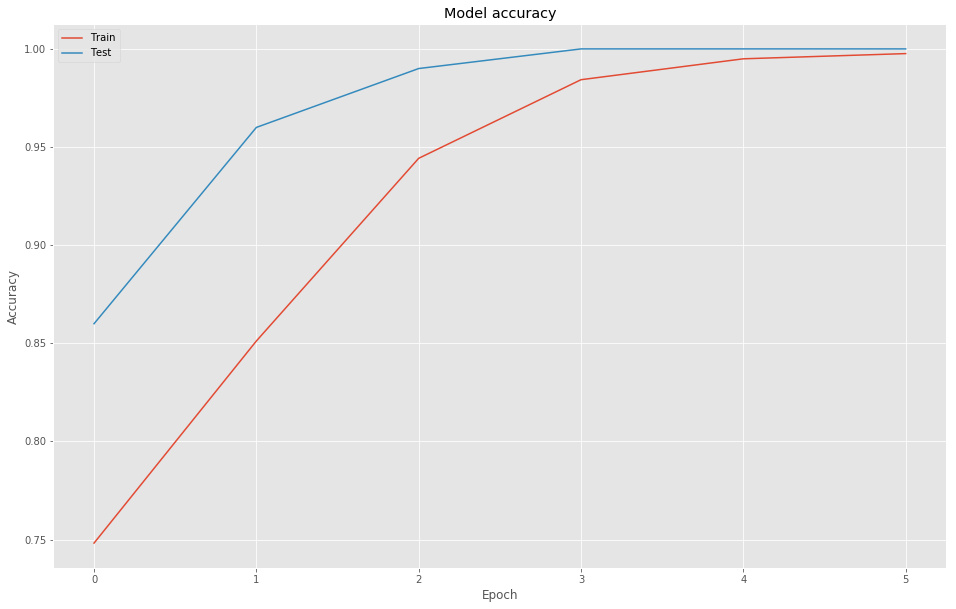

In [86]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [87]:
#Feature Analysis¶


In [88]:
all_names = [i.split() for i in X_train]


In [89]:
np.random.seed(1)
all_names_rand = [all_names[np.random.randint(low=1, high=150000)] for i in range(5000)]
print(len(all_names_rand))

5000


In [91]:
all_names_list = Word2Vec(all_names_rand, min_count=1)
all_names_vec = all_names_list[all_names_list.wv.vocab]
print(all_names[0])

['"It', 'has', 'no', 'side', 'effect,', 'I', 'take', 'it', 'in', 'combination', 'of', 'Bystolic', '5', 'Mg', 'and', 'Fish', 'Oil"']


C:\Users\arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [92]:
kclusterer_all = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=10)
assigned_clusters_all = kclusterer_all.cluster(all_names_vec, assign_clusters=True)
print(len(assigned_clusters_all))

28785


In [94]:
def generate_df(feature_names): 
    
    #  creates a zipped dictionary with every word from all of the reviews as a key and its assigned cluster as its value
    all_words_dict = dict(zip(all_names_list.wv.vocab, assigned_clusters_all))
    
    #iterates through and deletes any word that isn't a feature.
    for key in list(all_words_dict.keys()):
        if key in list(feature_names):
            pass
        else:
            del all_words_dict[key]
            
    #dictionary is then converted into nested list, with each inner list corresponding to one cluster.
    sorted_names = []
    for cluster in range(5):
        cluster_list = []
        for key, value in all_words_dict.items():
            if value == cluster:
                cluster_list.append(key)
        sorted_names.append(cluster_list)
        
    #inner list word features are sorted alphabetically then converted into a pandas DataFrame.
    for index, entry in enumerate(sorted_names):
        entry.sort()
    
    df_all = pd.DataFrame(sorted_names).T
    print(df_all[:50])
    
    #returns pandas dataframe with each cluster as a column and a list of lists where each list is all of the words assigned to that cluster.
    return df_all, sorted_names
    

df,sorted_names_all = generate_df(names.wv.vocab)

                0             1       2      3            4
0             10x           103      10    100          105
1            11pm         225mg  1000mg   1000         10pm
2             175           30s    10am  100mg          112
3             1am           4pm   10lbs    102          115
4              1x         50lbs    10th   10mg          130
5            2005           7pm      11    120          140
6            2006          8lbs     110   1200         16th
7             9pm           911    11th  120mg         2003
8            able       abdomen      12    125         2008
9          absorb     abdominal      13   12th         2010
10     accomplish      abnormal      14    135          210
11       accurate    absolutely      15   13th         22nd
12  acetaminophen        accept    1500    145        25lbs
13       achieved     according   15lbs   14th         28th
14            act          achy      16    150          3am
15         acting          acne     165 